##Time series forcasting for weather prediction

##What we are going to learn
+ What is time series
+ Time series analysis
+ example code

### What is Time series?

+ ***Time series*** is a certain sequence of data observations that a system collects within specific periods of time.
+ ***Time series*** analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data.
+ We will be using ***Jena Climate dataset*** recorded by the Max Planck Institute for Biogeochemistry. The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per 10 minutes.

### Time series analysis with Keras

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

### Load Jena Climate dataset

In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13582336/13568290 [==============================] - 0s 0us/step


### Raw Data Visualization
+ To give us a sense of the data we are working with, each feature has been plotted below. 
+ This shows the distinct pattern of each feature over the time peroid from 2009 to 2016.
+ It also shows where anomalies are present, which will be addressed during normalization.

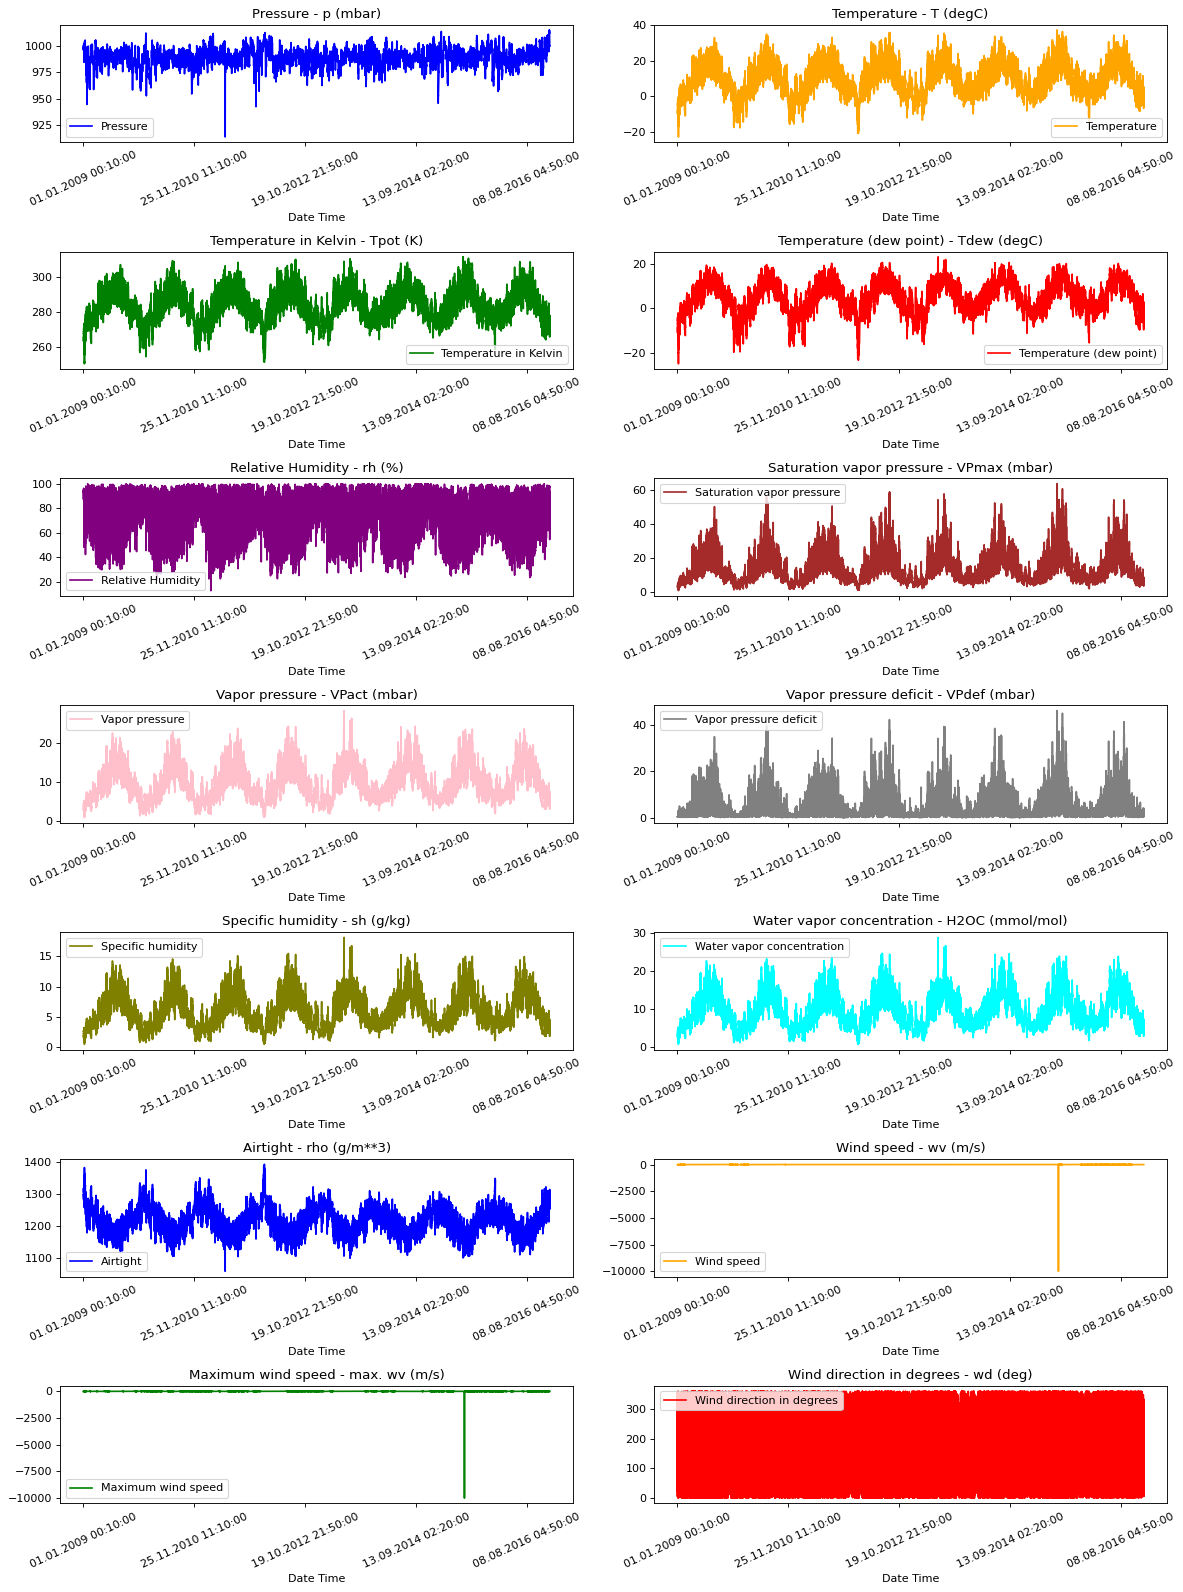

In [17]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## Heat map
+ This heat map shows the correlation between different features

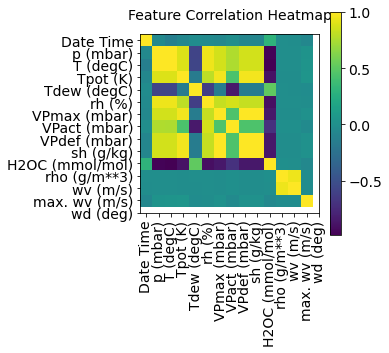

In [4]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

## Data preprocessing
+ ~300,000 data points for training. Observation is recorded every 10 mins.
+ resample one point per hour since no drastic change is expected within 60 minutes.
+ normalize to confine feature values to a range of [0,1] by subtracting the mean and dividing by the standard deviation of each feature.
+ The temperature after 72 observation will be used as a label.

In [5]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

## Feature selection
+ From the correlation heatmap, few parameters like Relative Humidity and Specific Humidity are redundant. Hence we will be using select features, not all.

In [6]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


## Training dataset
+ The training dataset labels starts from the 792nd observations

In [7]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [43]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
print("len(dataset_train):", len(dataset_train))

Input shape: (256, 120, 7)
Target shape: (256, 1)
len(dataset_train): 1172


## Validation dataset

In [44]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_val.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
print("len(dataset_val):", len(dataset_val))

Input shape: (256, 120, 7)
Target shape: (256, 1)
len(dataset_val): 463


## Training
+ ***ModelCheckpoint*** callback to regulary save checkpoints.
+ ***EarlyStopping*** callback to interrupt training when the validation loss is not longer improving

In [10]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [45]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.0977
Epoch 1: val_loss improved from inf to 0.12050, saving model to model_checkpoint.h5
1172/1172 [==============================] - 204s 174ms/step - loss: 0.0977 - val_loss: 0.1205
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.0967
Epoch 2: val_loss did not improve from 0.12050
1172/1172 [==============================] - 207s 177ms/step - loss: 0.0967 - val_loss: 0.1229
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 0.0959
Epoch 3: val_loss improved from 0.12050 to 0.11464, saving model to model_checkpoint.h5
1172/1172 [==============================] - 208s 177ms/step - loss: 0.0959 - val_loss: 0.1146
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.0950
Epoch 4: val_loss improved from 0.11464 to 0.11455, saving model to model_checkpoint.h5
1172/1172 [==============================] - 203s 174ms/step - loss: 0.0950 - val_loss: 0.11

## Plotting Loss curve

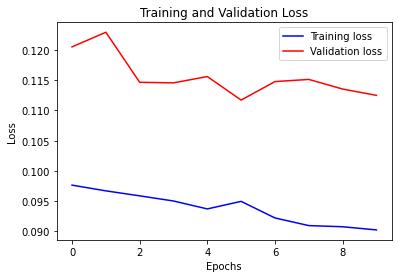

In [48]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Prediction
+ The trained model above is now able to make predictions for 5set of values from validation set.

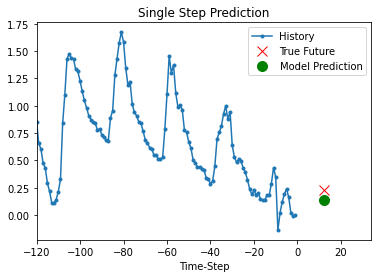

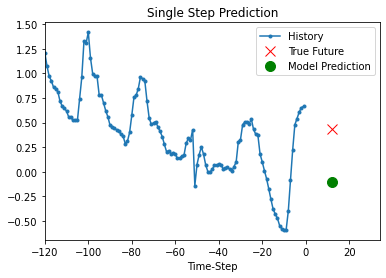

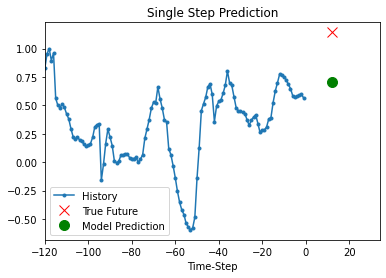

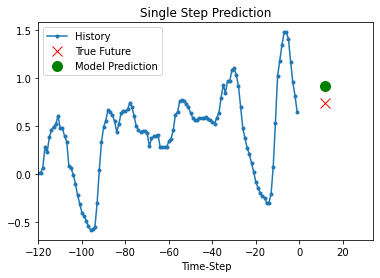

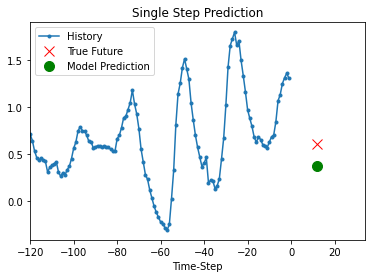

In [49]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )